In [1]:
%matplotlib inline
import collections
import glob
import h5py
import os
import re
import warnings
import numpy as np
import matplotlib.gridspec as gridspec
import TwissTable as tt
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit
from scipy import interpolate

In [2]:
madx_folder = "madx_run_II"
plane = "V"

In [3]:
# Function definitions

def gauss(x, a, b, c, d, e):
    return a*np.exp(-(x - b) ** 2 / (2 * c ** 2)) + d * x + e

def get_beta(run, plane):
    data_path = os.path.join("..", "madx", run)
    files = os.listdir(data_path)

    ctimes = []
    beta_x_h = []
    alpha_x_h = []
    beta_y_h = []
    alpha_y_h = []

    beta_x_v = []
    alpha_x_v = []
    beta_y_v = []
    alpha_y_v = []

    for f in files:
        if f.startswith("output"):
            ctime = re.search("R3_(.*)_0", f).group(1)
            file_path = os.path.join(data_path, f)
            tab = tt.TwissTable(file_path)
            tab.convertToNumpy()
            
            ws_h = tab.findDataIndex("NAME", "BR3.BWS.2L1.H_ROT")[0]

            ws_h_betx = tab.data["BETX"][ws_h]
            ws_h_bety = tab.data["BETY"][ws_h]
            ws_h_alphax = tab.data["ALFX"][ws_h]
            ws_h_alphay = tab.data["ALFY"][ws_h]
            ws_h_disp = tab.data["DISP"][ws_h]

            ctimes.append(ctime)
            beta_x_h.append(ws_h_betx)
            alpha_x_h.append(ws_h_alphax)
            beta_y_h.append(ws_h_bety)
            alpha_y_h.append(ws_h_alphay)
            
            
            ws_v = tab.findDataIndex("NAME", "BR3.BWS.2L1.V_ROT")[0]

            ws_v_betx = tab.data["BETX"][ws_v]
            ws_v_bety = tab.data["BETY"][ws_v]
            ws_v_alphax = tab.data["ALFX"][ws_v]
            ws_v_alphay = tab.data["ALFY"][ws_v]
            ws_v_disp = tab.data["DISP"][ws_v]

            beta_x_v.append(ws_v_betx)
            alpha_x_v.append(ws_v_alphax)
            beta_y_v.append(ws_v_bety)
            alpha_y_v.append(ws_v_alphay)
            

    if plane == "H":
        return ctimes, beta_x_h

    elif plane == "V":
        return ctimes, beta_y_v


def apply_fit(function, data_1, data_2, ind_var):
    
    mu_y = max(data_2)
    min_y = min(data_2)
    data_x = []
    data_y = []
    mu_x = []
    for x, y in zip(data_1, data_2):
        if y == mu_y:
            mu_x.append(x)
    for x, y in zip(data_1, data_2):
        if x - mu_x[0] > -20 and x - mu_x[0] < 20:
            data_x.append(x - mu_x[0])
            data_y.append((y - min_y) / mu_y)
    
    if ind_var == "space":
        try:
            popt, pcov = curve_fit(function, np.asarray(data_x), np.asarray(data_y))
            return np.asarray(data_x), np.asarray(data_y), popt, pcov
        except:
            print("")
            print("Fit of profile failed.")
            print("")
            return "NaN", "NaN"
        
        
def calculate_emittance(data_dict, sel_ctime, madx_folder, plane):
    sigma_wire = np.asarray(data_dict["sw"])
    sigma_grid_1 = np.asarray(data_dict["s1"])
    sigma_grid_2 = np.asarray(data_dict["s2"])
    sigma_grid_3 = np.asarray(data_dict["s3"])
    intensity = np.asarray(data_dict["i"])

    int_new = [x if (x > np.mean(intensity) - np.std(intensity)) else 0 for x in intensity]
    int_new = [x if (x < np.mean(intensity) + np.std(intensity)) else 0 for x in int_new]
    print("Recorded intensities:", intensity)
    print("Intensities after outlier exclusion:", int_new)
    
#     norm_sigma_wire = (sigma_wire / intensity) * np.mean(intensity)
#     norm_sigma_grid_1 = (sigma_grid_1 / intensity) * np.mean(intensity)
#     norm_sigma_grid_2 = (sigma_grid_2 / intensity) * np.mean(intensity)
#     norm_sigma_grid_3 = (sigma_grid_3 / intensity) * np.mean(intensity)
    
    ct_ws, beta_ws = get_beta(madx_folder, plane)
    
    fun_beta = interpolate.interp1d(np.asarray(ct_ws, dtype="float64"), beta_ws, kind='linear', fill_value='extrapolate')
    
    beta_wire = fun_beta(sel_ctime)
    print("Beta wire:", beta_wire)
    
    data = h5py.File("../beta_gamma.hdf5", 'r')
    ctime = np.asarray(list(data["ctime"]))
    beta = np.asarray(list(data["beta"]))
    gamma = np.asarray(list(data["gamma"]))
    
    beta_gamma = []
    
    for ct, b, g in zip(ctime, beta, gamma):
        if ct == sel_ctime:
            beta_gamma.append(b)
            beta_gamma.append(g)
            
    beta_rel = beta_gamma[0]    
    gamma_rel = beta_gamma[1]
    
    print("Beta rel:", beta_rel, "Gamma rel:", gamma_rel)
    
#     norm_emittance_wire = ((norm_sigma_wire)**2 / beta_wire) * beta_rel * gamma_rel
    emittance_wire = ((sigma_wire)**2 / beta_wire) * beta_rel * gamma_rel
    norm_emittance_wire = []
    for e, i in zip(emittance_wire, int_new):
        print(e, i)
        if i != 0:
            n_em = (e/i)*np.mean(int_new)
            norm_emittance_wire.append(n_em)
        else:
            print("An intensity value was excluded.")
    
    print("")
    print("Normal emittance:", emittance_wire, np.mean(emittance_wire), np.std(emittance_wire, dtype=np.float64))
    print("Normalized emittance:", norm_emittance_wire, np.mean(norm_emittance_wire), np.std(norm_emittance_wire, dtype=np.float64))
    print("Intensity:", intensity)
    print("")
    
    e_norm = [x for x in norm_emittance_wire if (x > np.mean(norm_emittance_wire) - 2 * np.std(norm_emittance_wire))]
    e_norm = [x for x in e_norm if (x < np.mean(norm_emittance_wire) + 2 * np.std(norm_emittance_wire))]
   
    print("Outliers excluded:", e_norm, np.mean(e_norm), np.std(e_norm, dtype=np.float64))
          
    return beta_wire, beta_rel, gamma_rel, np.mean(e_norm), np.std(e_norm, dtype=np.float64), np.mean(emittance_wire), np.std(emittance_wire, dtype=np.float64), np.mean(sigma_wire), np.std(sigma_wire), np.mean(intensity), np.std(intensity)  

def get_data(directory, sel_ctime):
#     plane = re.search('PROFILE_(.*)_2018', directory).group(1).replace("_", " ")
#     beam = re.search('(.*)_PROFILE', directory).group(1)
    bct_files = glob.glob(os.path.join(data_path, directory, "bct_shot*"))
    ws_files = glob.glob(os.path.join(data_path, directory, "wirescanner_shot*"))
    sem_files = glob.glob(os.path.join(data_path, directory, "semgrid_shot*"))
    
    bct_dict = collections.defaultdict(list)
    ws_dict = collections.defaultdict(list)
    sem_dict = collections.defaultdict(list)
    data_dict = collections.defaultdict(list)
    
    shots_bct = []
    shots_ws = []
    shots_sem = []
    
    for fb in bct_files:
        data_bct = h5py.File(fb, 'r')
        x = np.asarray(list(data_bct["ctime"]))
        y = np.asarray(list(data_bct["intensity"]))
        shot_bct = re.search('shot_(.*)_R', fb).group(1)
        shots_bct.append(shot_bct)
        bct_dict[(str(shot_bct), "x")] = x
        bct_dict[(str(shot_bct), "y")] = y
        
    for fw in ws_files:
        data_ws = h5py.File(fw, 'r')
        shot_ws = re.search('shot_(.*)_R', fw).group(1)
        shots_ws.append(shot_ws)
        ws_dict[(str(shot_ws), "x")] = np.asarray(list(data_ws["position"]))
        ws_dict[(str(shot_ws), "y")] = np.asarray(list(data_ws["intensity"]))
        ws_dict[(str(shot_ws), "z")] = np.asarray(list(data_ws["time"]))
        
    for fs in sem_files:
        data_sem = h5py.File(fs, 'r')
        x1 = np.asarray(list(data_sem["sem_1_x"]))
        y1 = np.asarray(list(data_sem["sem_1_y"]))
        x2 = np.asarray(list(data_sem["sem_2_x"]))
        y2 = np.asarray(list(data_sem["sem_2_y"]))
        x3 = np.asarray(list(data_sem["sem_3_x"]))
        y3 = np.asarray(list(data_sem["sem_3_y"]))
        shot_sem = re.search('shot_(.*)_R', fs).group(1)
        shots_sem.append(shot_sem)
        sem_dict[(str(shot_sem), "x1")] = x1
        sem_dict[(str(shot_sem), "y1")] = y1
        sem_dict[(str(shot_sem), "x2")] = x2
        sem_dict[(str(shot_sem), "y2")] = y2
        sem_dict[(str(shot_sem), "x3")] = x3
        sem_dict[(str(shot_sem), "y3")] = y3
        
        
    shot_list = list(set(shots_bct) & set(shots_ws) & set(shots_sem))

    for shot in shot_list:
        fig = plt.figure()
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
        plt.rcParams["figure.figsize"] = [10, 3]
        
        intensity = []
        for x_bct, y_bct in zip(bct_dict[(shot, "x")],  bct_dict[(shot, "y")]):
            if x_bct == sel_ctime:
                intensity.append(y_bct)
        ax1.scatter(bct_dict[(shot, "x")], bct_dict[(shot, "y")], s=0.3, color="black", label=str(intensity[0]))
        ax1.set_xlabel('ctime [ms]')
        ax1.set_ylabel(r'Intensity [$10^{10}$]')
        ax1.legend(fontsize=10, loc="upper right")
        
        x, y, popt, pcov = apply_fit(gauss, ws_dict[(shot, "x")]*1e-3, ws_dict[(shot, "y")], "space")
        perr = np.sqrt(np.diag(pcov))
        fit = r"$\sigma={:.3f}\pm{:.3f}$".format(popt[2], perr[2])
        
        ax2.scatter(x, y, s=0.3, color="black")
        ax2.plot(x, gauss(x, popt[0], popt[1], popt[2], popt[3], popt[4]), label=fit, lw=0.8, color='green')
        ax2.set_xlabel('Position [mm]')
        ax2.set_ylabel(r'Normalized amplitude')
        ax2.set_ylim([-0.05, max(y) + 0.2*max(y)])
        ax2.set_title(str(sel_ctime) + ", shot " + str(shot))
        ax2.legend(fontsize=10, loc="upper left")
        
        x1, y1, popt1, pcov1 = apply_fit(gauss, sem_dict[(shot, "x1")], sem_dict[(shot, "y1")], "space")
        perr1 = np.sqrt(np.diag(pcov1))
        fit1 = r"$\sigma={:.3f}\pm{:.3f}$".format(abs(popt1[2]), perr1[2])
        
        x2, y2, popt2, pcov2 = apply_fit(gauss, sem_dict[(shot, "x2")], sem_dict[(shot, "y2")], "space")
        perr2 = np.sqrt(np.diag(pcov2))
        fit2 = r"$\sigma={:.3f}\pm{:.3f}$".format(abs(popt2[2]), perr2[2])
        
        x3, y3, popt3, pcov3 = apply_fit(gauss, sem_dict[(shot, "x3")], sem_dict[(shot, "y3")], "space")
        perr3 = np.sqrt(np.diag(pcov3))
        fit3 = r"$\sigma={:.3f}\pm{:.3f}$".format(abs(popt3[2]), perr3[2])
        
        ax3.scatter(x1, y1, s=0.5, color='blue')
        ax3.plot(x1, gauss(x1, popt1[0], popt1[1], popt1[2], popt1[3], popt1[4]), label="Grid 1: " + fit1, lw=0.8, color='blue')
        ax3.scatter(x2, y2, s=0.5, color='green')
        ax3.plot(x2, gauss(x2, popt2[0], popt2[1], popt2[2], popt2[3], popt2[4]), label="Grid 2: " + fit2, lw=0.8, color='green')
        ax3.scatter(x3, y3, s=0.5, color='orange')
        ax3.plot(x3, gauss(x3, popt3[0], popt3[1], popt3[2], popt3[3], popt3[4]), label="Grid 3: " + fit3, lw=0.8, color='orange')
        ax3.legend(fontsize=10, loc="upper left")
        
        ax3.set_ylim([-0.05, 2])
        
        ax3.set_xlabel('Position [mm]')
        ax3.set_ylabel(r'Normalized amplitude')
        
#         ax3.plot(sem_dict[(shot, "x1")], sem_dict[(shot, "y1")])
#         ax3.plot(sem_dict[(shot, "x2")], sem_dict[(shot, "y2")])
#         ax3.plot(sem_dict[(shot, "x3")], sem_dict[(shot, "y3")])
        
        plt.tight_layout()
        plt.show()
        
        data_dict["sw"].append(popt[2])
        data_dict["s1"].append(popt1[2])
        data_dict["s2"].append(popt2[2])
        data_dict["s3"].append(popt3[2])
        data_dict["i"].append(intensity[0])
        
    return data_dict

In [4]:
# Specify the folder where the data is with respect to the location of this notebook
data_path = os.path.join(os.getcwd(), "results")

result_folders = [x[0].strip(data_path) for x in os.walk(data_path)][1:]
# result_folders = [d for d in os.listdir(data_path) if os.path.isdir(data_path)]
# result_folders.remove('tomoscope')

print(result_folders)

['PROFILE_NEW_TUNE_675_V_R3_2018_10_15_12_25', 'PROFILE_NEW_TUNE_310_V_R3_2018_10_15_11_17', 'PROFILE_NEW_TUNE_430_V_R3_2018_10_15_12_00', 'PROFILE_NEW_TUNE_600_V_R3_2018_10_15_12_21', 'PROFILE_NEW_TUNE_550_V_R3_2018_10_15_12_18', 'PROFILE_NEW_TUNE_320_V_R3_2018_10_15_11_21', 'PROFILE_NEW_TUNE_795_V_R3_2018_10_15_12_32', 'PROFILE_NEW_TUNE_470_V_R3_2018_10_15_12_10', 'PROFILE_NEW_TUNE_400_V_R3_2018_10_15_11_55', 'PROFILE_NEW_TUNE_375_V_R3_2018_10_15_11_51', 'PROFILE_NEW_TUNE_325_V_R3_2018_10_15_11_26', 'PROFILE_NEW_TUNE_300_V_R3_2018_10_15_11_13', 'PROFILE_NEW_TUNE_500_V_R3_2018_10_15_12_15', 'PROFILE_NEW_TUNE_450_V_R3_2018_10_15_12_04', 'PROFILE_NEW_TUNE_730_V_R3_2018_10_15_12_29', 'PROFILE_NEW_TUNE_360_V_R3_2018_10_15_11_46', 'PROFILE_NEW_TUNE_350_V_R3_2018_10_15_11_41', 'PROFILE_NEW_TUNE_340_V_R3_2018_10_15_11_31', 'PROFILE_NEW_TUNE_285_V_R3_2018_10_15_11_08']



PROFILE_NEW_TUNE_675_V_R3_2018_10_15_12_25


/usr/local/lib/python3.6/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


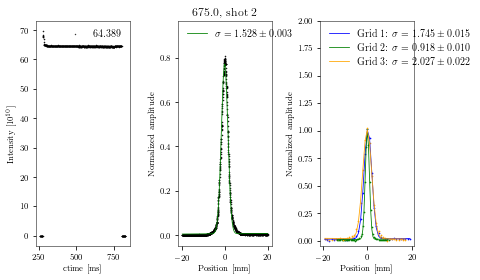

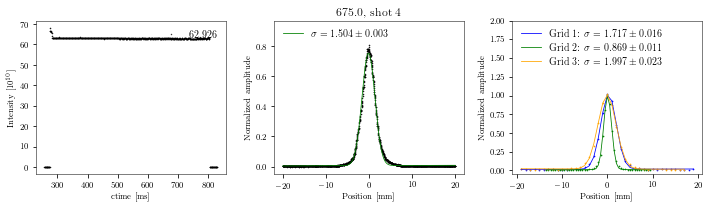

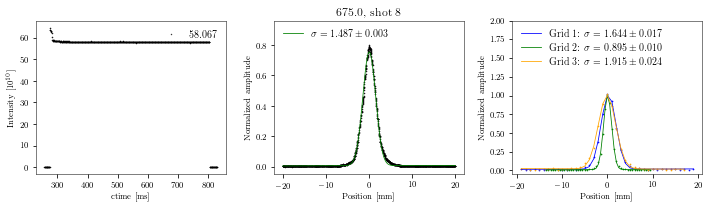

Recorded intensities: [ 64.389  62.926  61.378  58.067]
Intensities after outlier exclusion: [0, 62.926000000000002, 61.378, 0]
Beta wire: 4.2719600893
Beta rel: 0.89503 Gamma rel: 2.24208
1.09619170763 0
An intensity value was excluded.
1.06263168655 62.926
1.10165052982 61.378
1.03832610262 0
An intensity value was excluded.

Normal emittance: [ 1.09619171  1.06263169  1.10165053  1.0383261 ] 1.07470000666 0.0257727043312
Normalized emittance: [0.52478057227915664, 0.55777138167893736] 0.541275976979 0.0164954046999
Intensity: [ 64.389  62.926  61.378  58.067]

Outliers excluded: [0.52478057227915664, 0.55777138167893736] 0.541275976979 0.0164954046999

PROFILE_NEW_TUNE_310_V_R3_2018_10_15_11_17


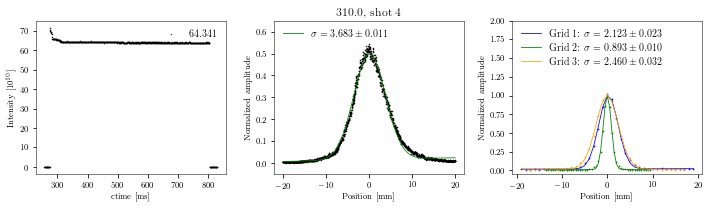

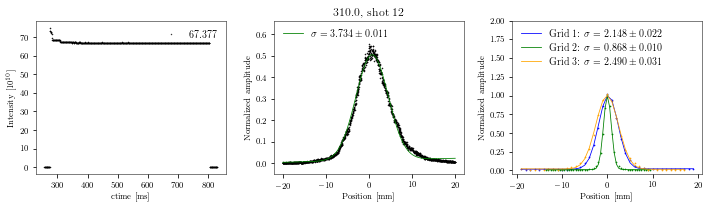

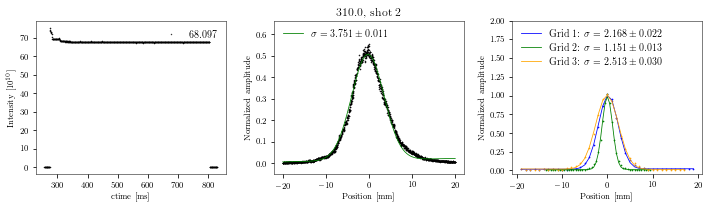

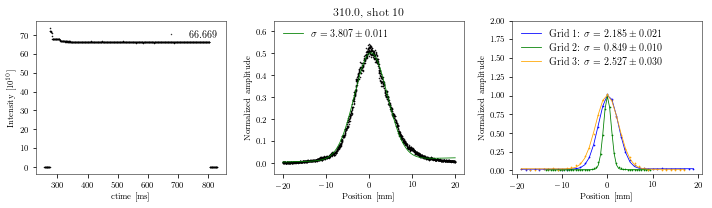

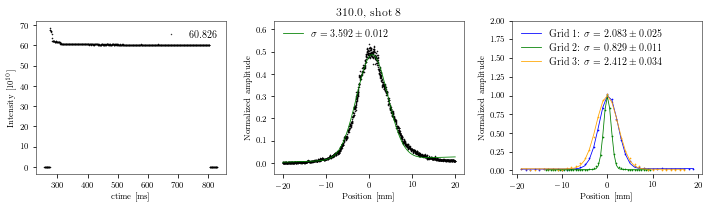

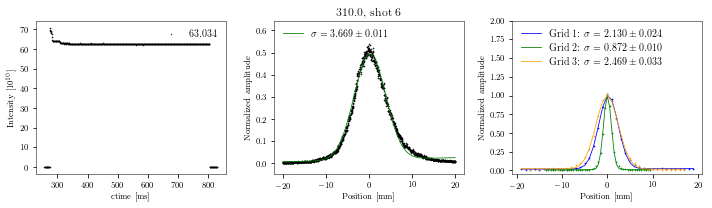

Recorded intensities: [ 64.341  68.253  67.377  68.097  66.669  60.826  63.034]
Intensities after outlier exclusion: [64.341000000000008, 0, 67.376999999999995, 68.097000000000008, 66.668999999999997, 0, 63.033999999999999]
Beta wire: 4.0754868711
Beta rel: 0.35976 Gamma rel: 1.07176
1.28318655218 64.341
1.35183323041 0
An intensity value was excluded.
1.31894493665 67.377
1.33084557019 68.097
1.37094617916 66.669
1.22081055844 0
An intensity value was excluded.
1.2732718001 63.034

Normal emittance: [ 1.28318655  1.35183323  1.31894494  1.33084557  1.37094618  1.22081056
  1.2732718 ] 1.30711983245 0.0477248306014
Normalized emittance: [0.93882164960376713, 0.92150160957074456, 0.91998508555408398, 0.9680049263965147, 0.95088359802862987] 0.939839373831 0.0181481424014
Intensity: [ 64.341  68.253  67.377  68.097  66.669  60.826  63.034]

Outliers excluded: [0.93882164960376713, 0.92150160957074456, 0.91998508555408398, 0.9680049263965147, 0.95088359802862987] 0.939839373831 0.01814814

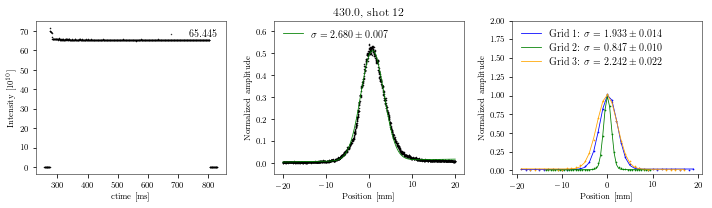

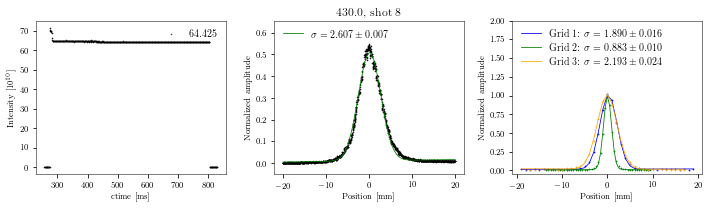

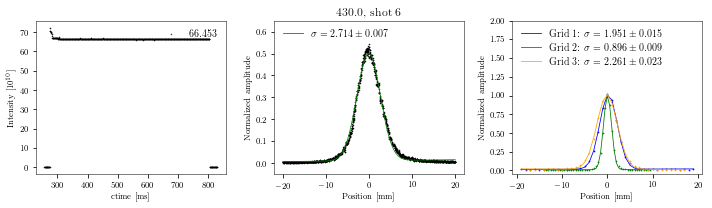

Recorded intensities: [ 59.842  63.322  65.445  65.085  61.234  64.425  66.453]
Intensities after outlier exclusion: [0, 63.322000000000003, 65.445000000000007, 65.085000000000008, 0, 64.424999999999997, 0]
Beta wire: 4.2033858446500005
Beta rel: 0.58113 Gamma rel: 1.22879
1.06455611739 0
An intensity value was excluded.
1.22361853267 63.322
1.22048334887 65.445
1.20846816464 65.085
1.19337156172 0
An intensity value was excluded.
1.15478702714 64.425
1.25162608308 0
An intensity value was excluded.

Normal emittance: [ 1.06455612  1.22361853  1.22048335  1.20846816  1.19337156  1.15478703
  1.25162608] 1.18813011936 0.0575217982446
Normalized emittance: [0.71298290317244595, 0.68808656755738484, 0.6850811184465605, 0.66135579357996299] 0.686876595689 0.0182861860509
Intensity: [ 59.842  63.322  65.445  65.085  61.234  64.425  66.453]

Outliers excluded: [0.71298290317244595, 0.68808656755738484, 0.6850811184465605, 0.66135579357996299] 0.686876595689 0.0182861860509

PROFILE_NEW_TUNE_

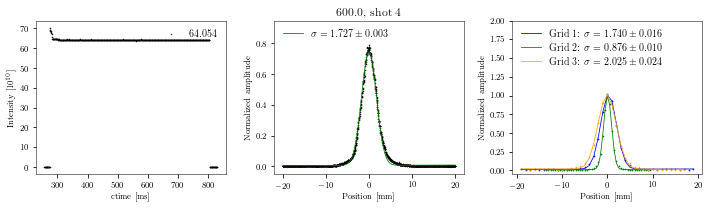

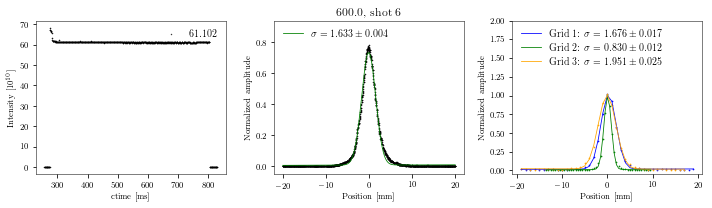

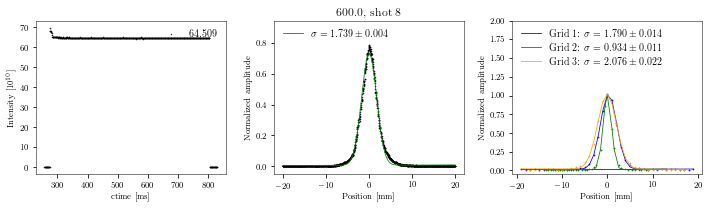

Recorded intensities: [ 61.078  64.054  61.102  64.509]
Intensities after outlier exclusion: [0, 64.054000000000002, 61.102000000000004, 0]
Beta wire: 4.2569297752
Beta rel: 0.84468 Gamma rel: 1.86823
1.02886552858 0
An intensity value was excluded.
1.10550546879 64.054
0.988663948266 61.102
1.12098126581 0
An intensity value was excluded.

Normal emittance: [ 1.02886553  1.10550547  0.98866395  1.12098127] 1.06100405286 0.0544141929288
Normalized emittance: [0.54001562139747183, 0.50627321981763096] 0.523144420608 0.0168712007899
Intensity: [ 61.078  64.054  61.102  64.509]

Outliers excluded: [0.54001562139747183, 0.50627321981763096] 0.523144420608 0.0168712007899

PROFILE_NEW_TUNE_550_V_R3_2018_10_15_12_18


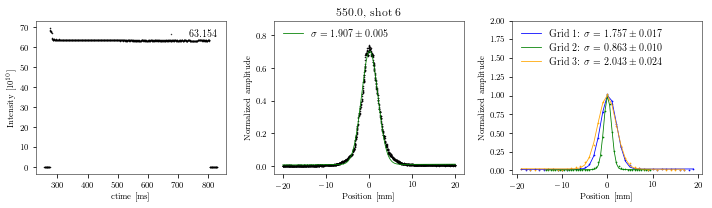

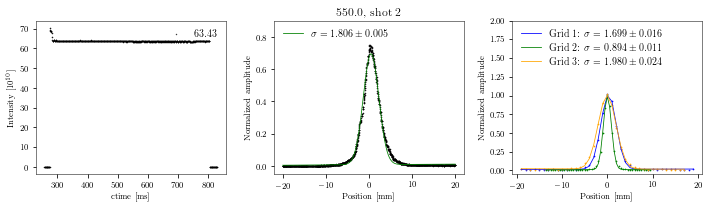

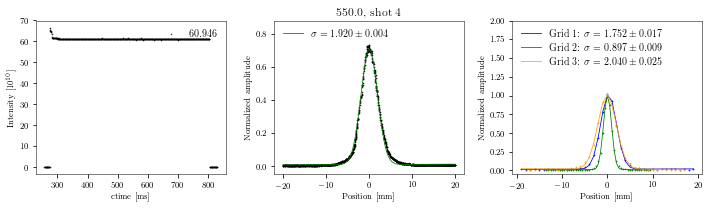

Recorded intensities: [ 63.154  63.43   62.818  60.946]
Intensities after outlier exclusion: [63.154000000000003, 63.43, 62.817999999999998, 0]
Beta wire: 4.24597088415
Beta rel: 0.78965 Gamma rel: 1.62983
1.10242084648 63.154
0.988394853981 63.43
1.12067416095 62.818
1.11790530526 0
An intensity value was excluded.

Normal emittance: [ 1.10242085  0.98839485  1.12067416  1.11790531] 1.08234879167 0.0546885028618
Normalized emittance: [0.82655379376449978, 0.737836836408852, 0.84473370464148023] 0.803041444938 0.0467001643108
Intensity: [ 63.154  63.43   62.818  60.946]

Outliers excluded: [0.82655379376449978, 0.737836836408852, 0.84473370464148023] 0.803041444938 0.0467001643108

PROFILE_NEW_TUNE_320_V_R3_2018_10_15_11_21


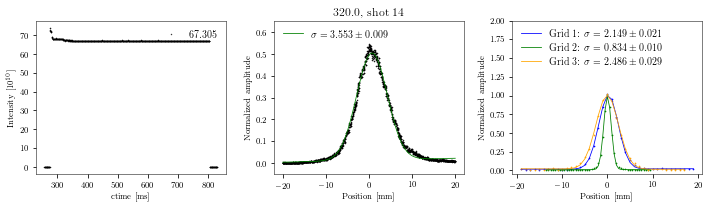

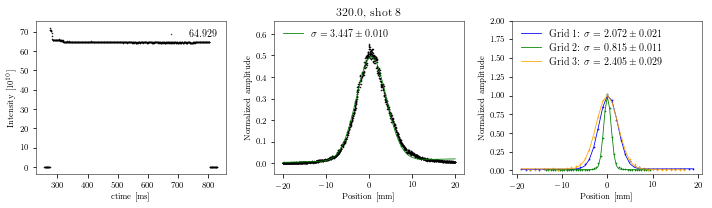

Recorded intensities: [ 61.99   67.305  64.473  64.245  61.822  64.929  64.341]
Intensities after outlier exclusion: [0, 0, 64.472999999999999, 64.245000000000005, 0, 64.929000000000002, 64.341000000000008]
Beta wire: 4.0898891664
Beta rel: 0.37581 Gamma rel: 1.0791
1.13955583967 0
An intensity value was excluded.
1.25138153511 0
An intensity value was excluded.
1.17089415536 64.473
1.19900690184 64.245
1.16940525811 0
An intensity value was excluded.
1.17842952704 64.929
1.19839864834 64.341

Normal emittance: [ 1.13955584  1.25138154  1.17089416  1.1990069   1.16940526  1.17842953
  1.19839865] 1.18672455221 0.0323196542761
Normalized emittance: [0.66933143963214503, 0.68783427857877599, 0.66890796501510907, 0.68645957917694567] 0.678133315601 0.00902794912807
Intensity: [ 61.99   67.305  64.473  64.245  61.822  64.929  64.341]

Outliers excluded: [0.66933143963214503, 0.68783427857877599, 0.66890796501510907, 0.68645957917694567] 0.678133315601 0.00902794912807

PROFILE_NEW_TUNE_795

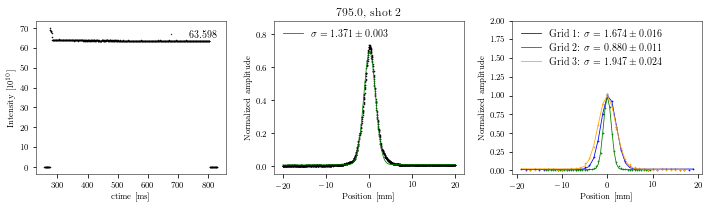

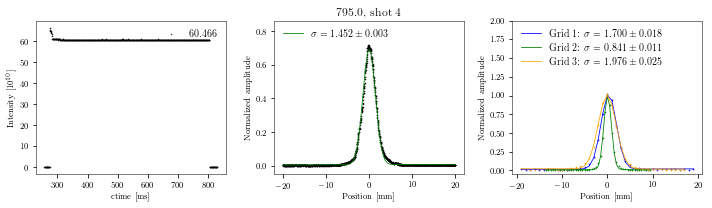

Recorded intensities: [ 63.598  60.466  68.385  62.134]
Intensities after outlier exclusion: [63.597999999999999, 0, 0, 62.134]
Beta wire: 4.2780021384
Beta rel: 0.91495 Gamma rel: 2.47794
0.995418374152 63.598
1.11666131453 0
An intensity value was excluded.
1.13003761963 0
An intensity value was excluded.
1.03566415442 62.134

Normal emittance: [ 0.99541837  1.11666131  1.13003762  1.03566415] 1.06944536568 0.0559507211161
Normalized emittance: [0.49198065591254919, 0.52393265145856938] 0.507956653686 0.015975997773
Intensity: [ 63.598  60.466  68.385  62.134]

Outliers excluded: [0.49198065591254919, 0.52393265145856938] 0.507956653686 0.015975997773

PROFILE_NEW_TUNE_470_V_R3_2018_10_15_12_10


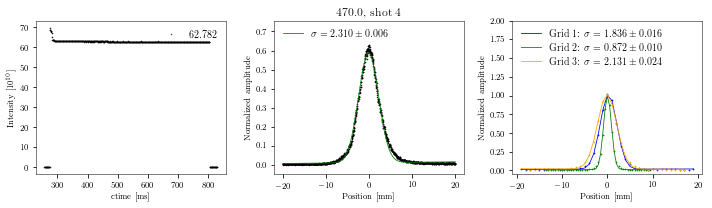

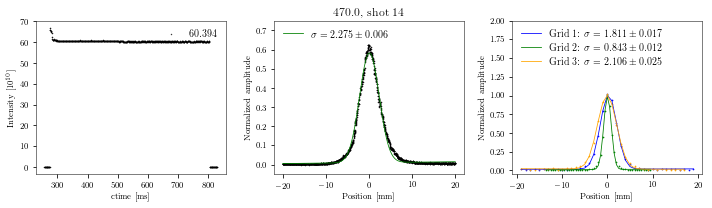

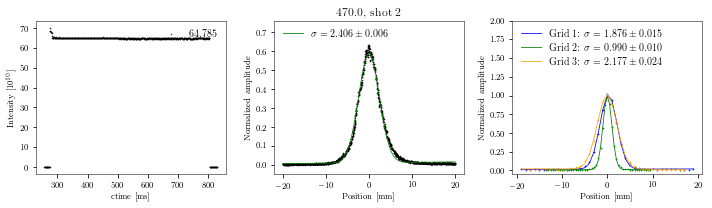

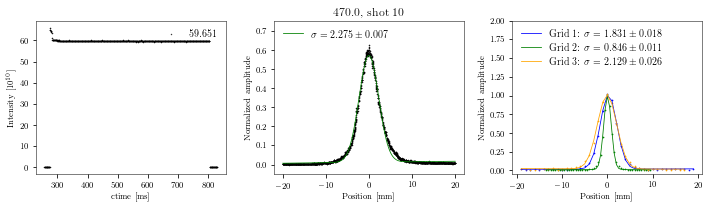

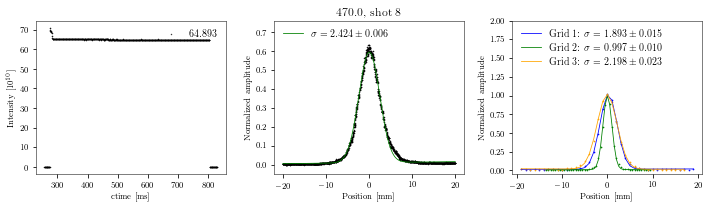

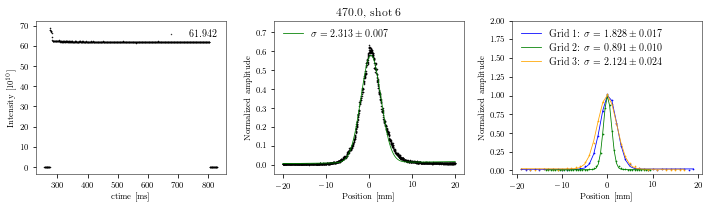

Recorded intensities: [ 62.782  60.394  57.791  64.785  59.651  64.893  61.942]
Intensities after outlier exclusion: [62.782000000000004, 60.393999999999998, 0, 0, 59.651000000000003, 0, 61.942]
Beta wire: 4.22712945885
Beta rel: 0.65911 Gamma rel: 1.32971
1.10659001351 62.782
1.07354466991 60.394
1.05261534206 0
An intensity value was excluded.
1.20057298758 0
An intensity value was excluded.
1.07301915351 59.651
1.21820454212 0
An intensity value was excluded.
1.10951924518 61.942

Normal emittance: [ 1.10659001  1.07354467  1.05261534  1.20057299  1.07301915  1.21820454
  1.10951925] 1.11915227912 0.0601507293867
Normalized emittance: [0.61632526842770619, 0.62156234845945413, 0.62899634106179625, 0.6263368868648006] 0.623305211203 0.00483055866534
Intensity: [ 62.782  60.394  57.791  64.785  59.651  64.893  61.942]

Outliers excluded: [0.61632526842770619, 0.62156234845945413, 0.62899634106179625, 0.6263368868648006] 0.623305211203 0.00483055866534

PROFILE_NEW_TUNE_400_V_R3_2018_1

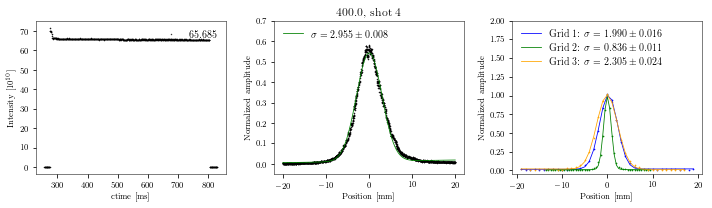

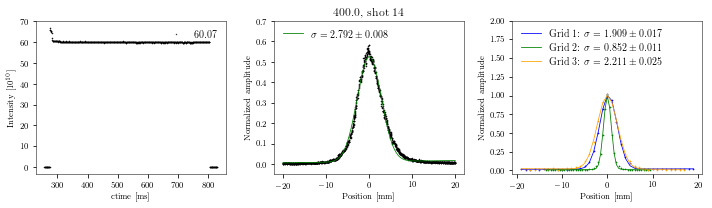

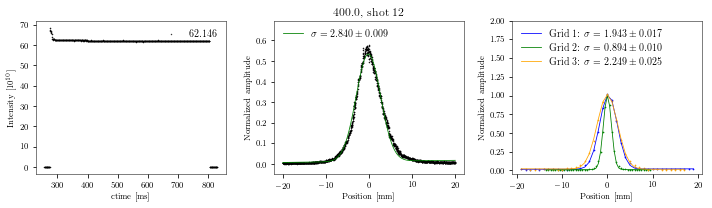

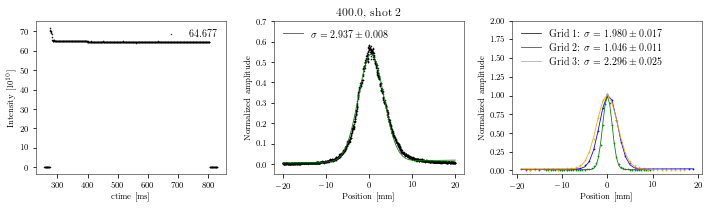

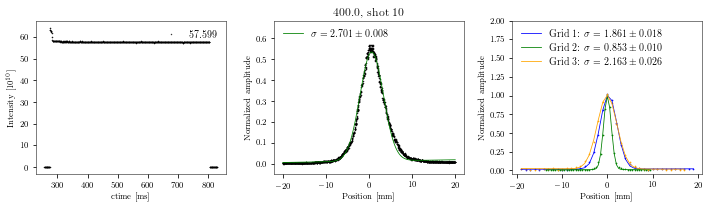

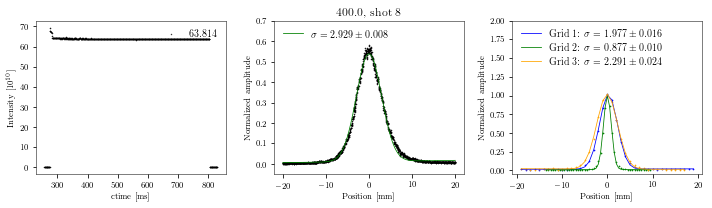

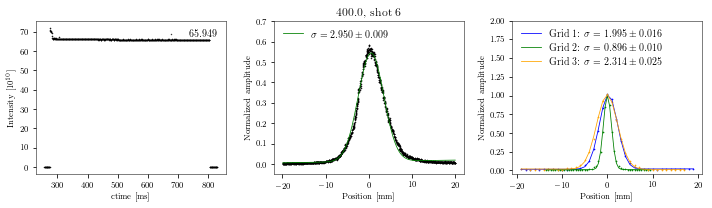

Recorded intensities: [ 65.685  60.07   62.146  64.677  57.599  63.814  65.949]
Intensities after outlier exclusion: [65.685000000000002, 60.07, 62.146000000000001, 64.677000000000007, 0, 63.814, 0]
Beta wire: 4.1798114319
Beta rel: 0.52149 Gamma rel: 1.17198
1.27641899836 65.685
1.13949821747 60.07
1.17918683179 62.146
1.26138919597 64.677
1.06678319179 0
An intensity value was excluded.
1.25460752875 63.814
1.27236388881 0
An intensity value was excluded.

Normal emittance: [ 1.276419    1.13949822  1.17918683  1.2613892   1.06678319  1.25460753
  1.27236389] 1.20717826471 0.0749349151425
Normalized emittance: [0.87832351315011059, 0.8573999857846345, 0.85762393645341384, 0.88150888368611136, 0.88862673492563971] 0.8726966108 0.0128394648405
Intensity: [ 65.685  60.07   62.146  64.677  57.599  63.814  65.949]

Outliers excluded: [0.87832351315011059, 0.8573999857846345, 0.85762393645341384, 0.88150888368611136, 0.88862673492563971] 0.8726966108 0.0128394648405

PROFILE_NEW_TUNE_375_V

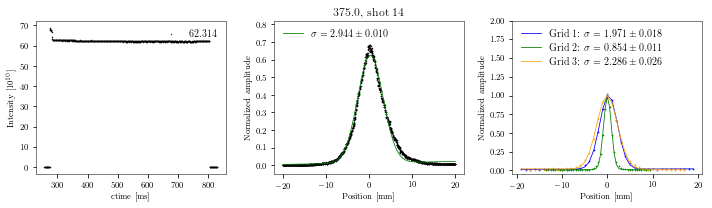

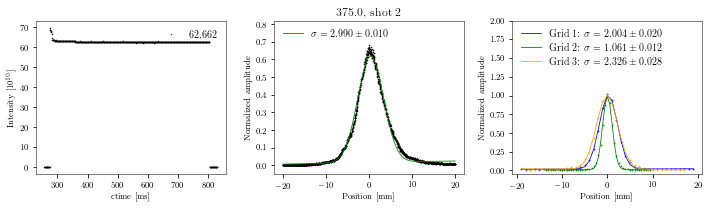

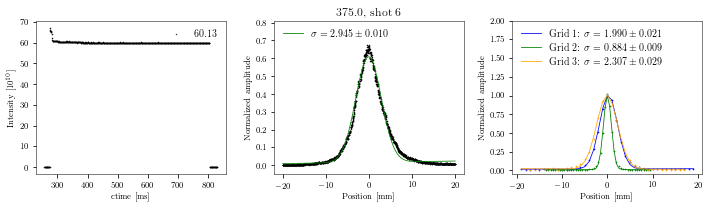

Recorded intensities: [ 67.725  62.314  67.521  62.662  65.421  60.994  60.13 ]
Intensities after outlier exclusion: [0, 62.314, 0, 62.661999999999999, 65.421000000000006, 60.994, 0]
Beta wire: 4.1561805113
Beta rel: 0.47317 Gamma rel: 1.13511
1.25391638705 0
An intensity value was excluded.
1.1198794341 62.314
1.31618679262 0
An intensity value was excluded.
1.155163961 62.662
1.23212970608 65.421
1.16651471736 60.994
1.12083996623 0
An intensity value was excluded.

Normal emittance: [ 1.25391639  1.11987943  1.31618679  1.15516396  1.23212971  1.16651472
  1.12083997] 1.19494728064 0.0687408241629
Normalized emittance: [0.64541242926162479, 0.66205041861546998, 0.67638027750225771, 0.68683875536194483] 0.667670470185 0.0155747332683
Intensity: [ 67.725  62.314  67.521  62.662  65.421  60.994  60.13 ]

Outliers excluded: [0.64541242926162479, 0.66205041861546998, 0.67638027750225771, 0.68683875536194483] 0.667670470185 0.0155747332683

PROFILE_NEW_TUNE_325_V_R3_2018_10_15_11_26


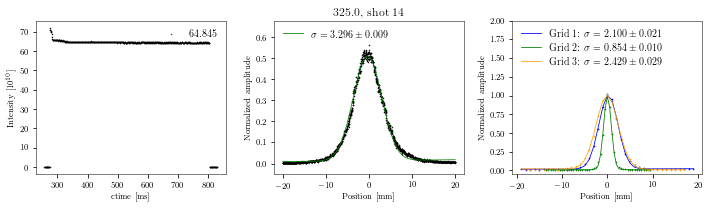

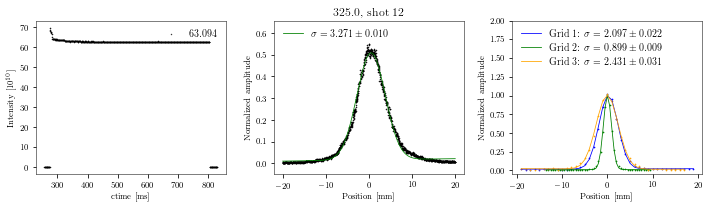

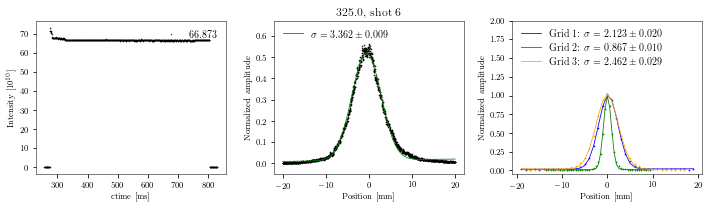

Recorded intensities: [ 65.973  64.845  63.094  61.042  61.09   62.362  66.873]
Intensities after outlier exclusion: [0, 64.844999999999999, 63.094000000000001, 0, 0, 62.362000000000002, 0]
Beta wire: 4.0968278361
Beta rel: 0.38404 Gamma rel: 1.08305
1.16052211346 0
An intensity value was excluded.
1.103103115 64.845
1.08604792131 63.094
1.0784508468 0
An intensity value was excluded.
1.0753045534 0
An intensity value was excluded.
1.05867362831 62.362
1.14770732332 0
An intensity value was excluded.

Normal emittance: [ 1.16052211  1.10310312  1.08604792  1.07845085  1.07530455  1.05867363
  1.14770732] 1.10140135737 0.03568024304
Normalized emittance: [0.46246902148623176, 0.46795485528206116, 0.46151422373043788] 0.463979366833 0.00283799119045
Intensity: [ 65.973  64.845  63.094  61.042  61.09   62.362  66.873]

Outliers excluded: [0.46246902148623176, 0.46795485528206116, 0.46151422373043788] 0.463979366833 0.00283799119045

PROFILE_NEW_TUNE_300_V_R3_2018_10_15_11_13


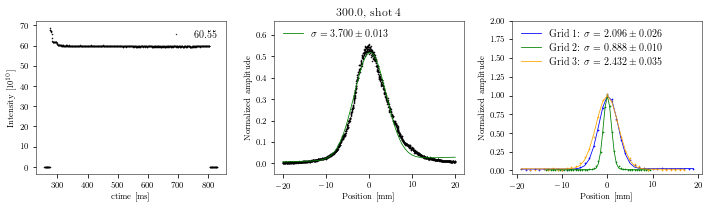

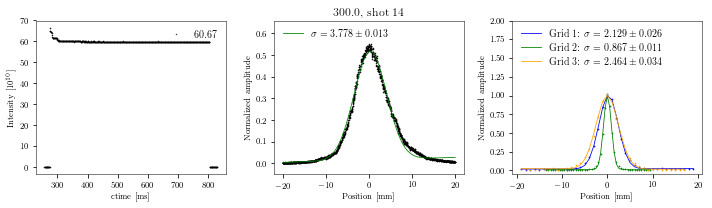

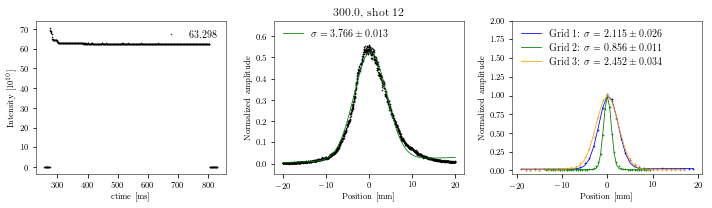

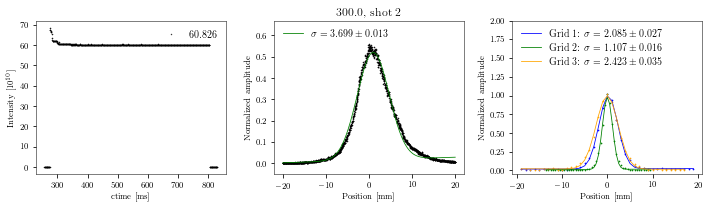

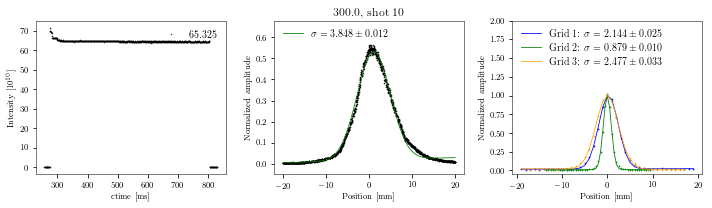

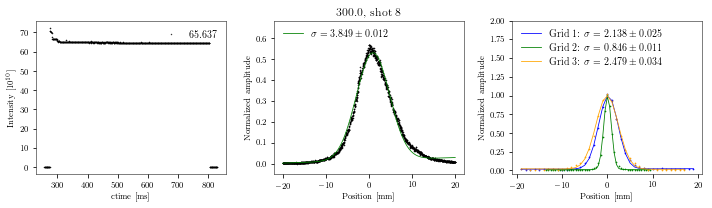

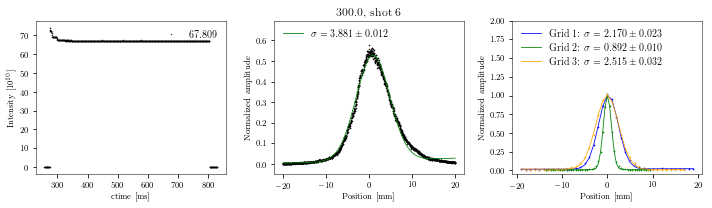

Recorded intensities: [ 60.55   60.67   63.298  60.826  65.325  65.637  67.809]
Intensities after outlier exclusion: [0, 0, 63.298000000000002, 60.826000000000001, 65.325000000000003, 65.637, 0]
Beta wire: 4.0601386118
Beta rel: 0.34446 Gamma rel: 1.06519
1.23735079711 0
An intensity value was excluded.
1.29004768318 0
An intensity value was excluded.
1.28167696514 63.298
1.23619671535 60.826
1.3379294529 65.325
1.33901372942 65.637
1.3609573354 0
An intensity value was excluded.

Normal emittance: [ 1.2373508   1.29004768  1.28167697  1.23619672  1.33792945  1.33901373
  1.36095734] 1.29759609693 0.0463936940622
Normalized emittance: [0.73786544898468809, 0.74060546320145393, 0.74634972920400644, 0.74340399509748301] 0.742056159122 0.00315903371202
Intensity: [ 60.55   60.67   63.298  60.826  65.325  65.637  67.809]

Outliers excluded: [0.73786544898468809, 0.74060546320145393, 0.74634972920400644, 0.74340399509748301] 0.742056159122 0.00315903371202

PROFILE_NEW_TUNE_500_V_R3_2018_10

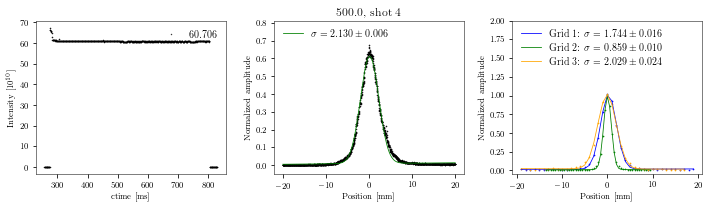

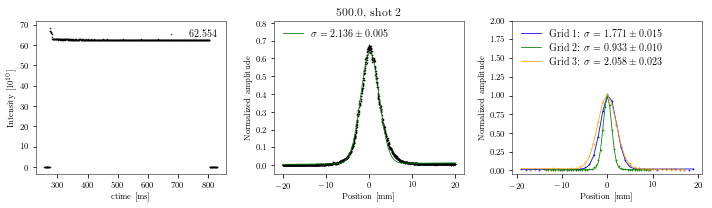

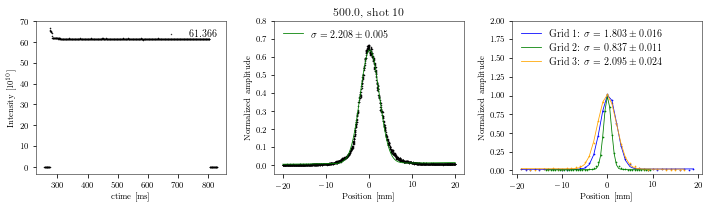

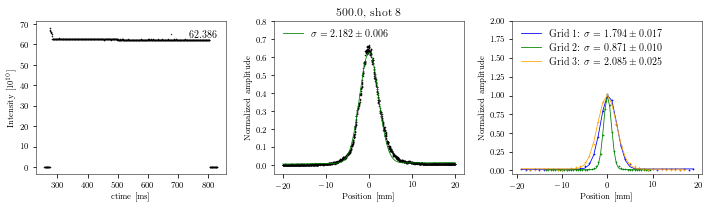

Recorded intensities: [ 60.706  62.554  61.366  62.386  61.882]
Intensities after outlier exclusion: [0, 0, 61.366, 62.386000000000003, 61.881999999999998]
Beta wire: 4.2363241580499995
Beta rel: 0.71309 Gamma rel: 1.42638
1.08904593188 0
An intensity value was excluded.
1.09547536631 0
An intensity value was excluded.
1.17036470369 61.366
1.14302471869 62.386
1.03816531969 61.882

Normal emittance: [ 1.08904593  1.09547537  1.1703647   1.14302472  1.03816532] 1.10721520805 0.045838877421
Normalized emittance: [0.70807770232844358, 0.68023034215996836, 0.62285892813628796] 0.670388990875 0.0354795623333
Intensity: [ 60.706  62.554  61.366  62.386  61.882]

Outliers excluded: [0.70807770232844358, 0.68023034215996836, 0.62285892813628796] 0.670388990875 0.0354795623333

PROFILE_NEW_TUNE_450_V_R3_2018_10_15_12_04


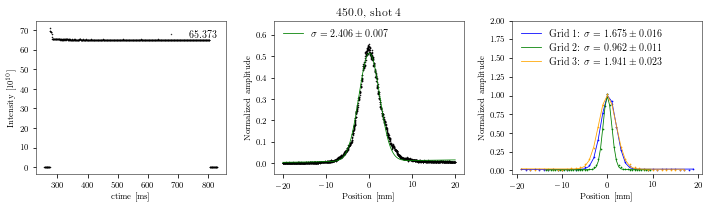

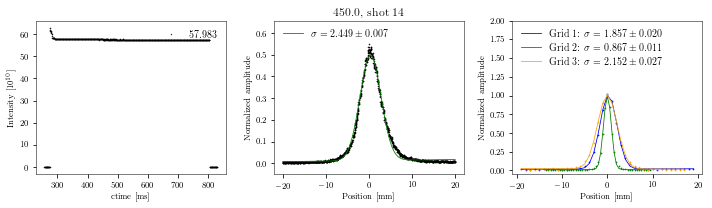

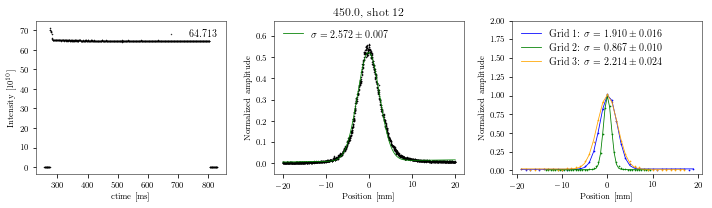

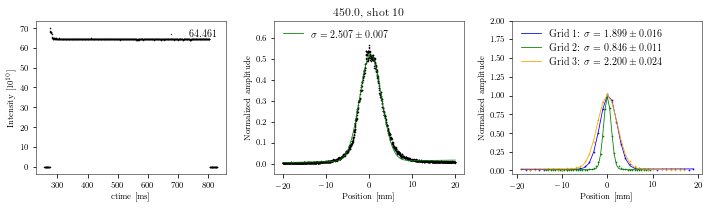

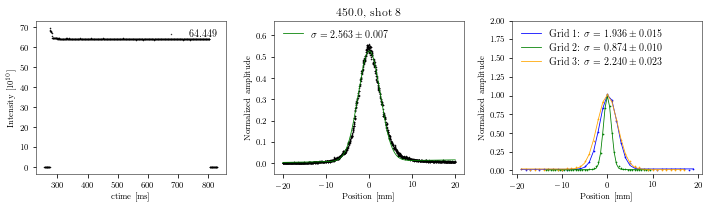

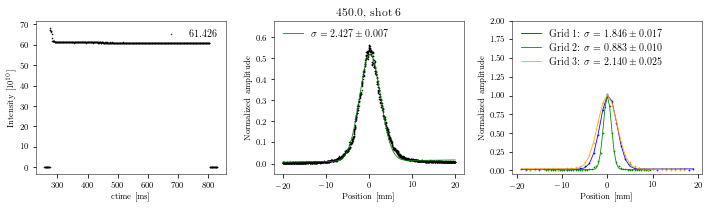

Recorded intensities: [ 65.373  57.983  64.713  64.461  64.449  61.426]
Intensities after outlier exclusion: [65.373000000000005, 0, 64.713000000000008, 64.460999999999999, 64.448999999999998, 61.426000000000002]
Beta wire: 4.2170140207
Beta rel: 0.62059 Gamma rel: 1.27529
1.08616425734 65.373
1.12570748179 0
An intensity value was excluded.
1.2414251292 64.713
1.17982230455 64.461
1.2323808309 64.449
1.10528259509 61.426

Normal emittance: [ 1.08616426  1.12570748  1.24142513  1.1798223   1.23238083  1.1052826 ] 1.16179709981 0.060365926919
Normalized emittance: [0.88729527395584418, 1.0244719575858205, 0.97744119821589281, 1.0211741857848793, 0.96093092958427107] 0.974262709025 0.0499456288216
Intensity: [ 65.373  57.983  64.713  64.461  64.449  61.426]

Outliers excluded: [0.88729527395584418, 1.0244719575858205, 0.97744119821589281, 1.0211741857848793, 0.96093092958427107] 0.974262709025 0.0499456288216

PROFILE_NEW_TUNE_730_V_R3_2018_10_15_12_29


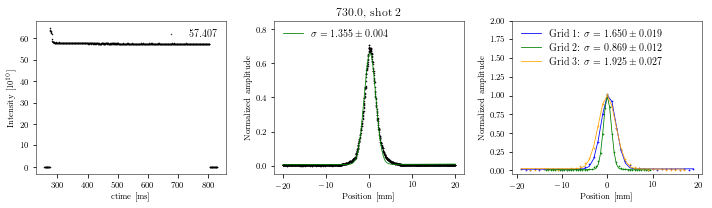

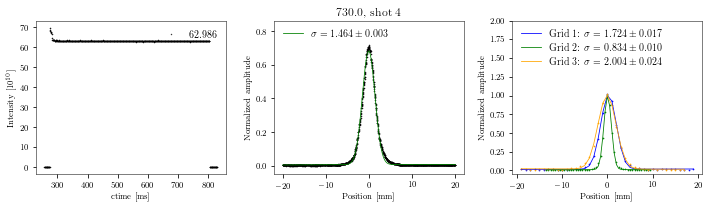

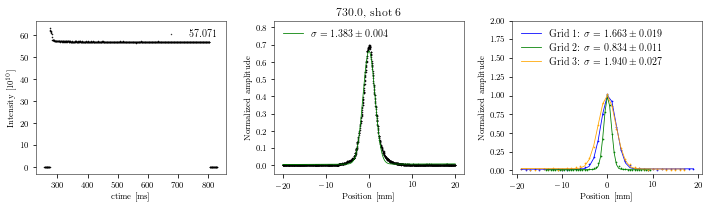

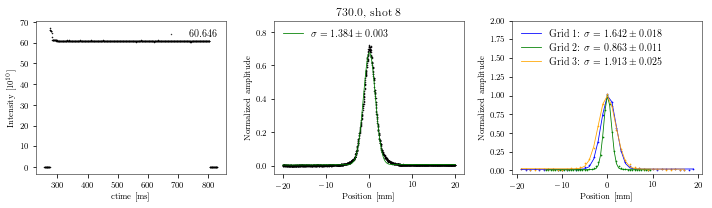

Recorded intensities: [ 57.407  62.986  57.071  60.646]
Intensities after outlier exclusion: [57.407000000000004, 0, 0, 60.646000000000001]
Beta wire: 4.2731530024
Beta rel: 0.91195 Gamma rel: 2.43728
0.955081284554 57.407
1.11464915781 0
An intensity value was excluded.
0.994367176109 0
An intensity value was excluded.
0.996766535547 60.646

Normal emittance: [ 0.95508128  1.11464916  0.99436718  0.99676654] 1.01521603851 0.0597456966446
Normalized emittance: [0.49101246749287325, 0.48507436525451558] 0.488043416374 0.00296905111918
Intensity: [ 57.407  62.986  57.071  60.646]

Outliers excluded: [0.49101246749287325, 0.48507436525451558] 0.488043416374 0.00296905111918

PROFILE_NEW_TUNE_360_V_R3_2018_10_15_11_46


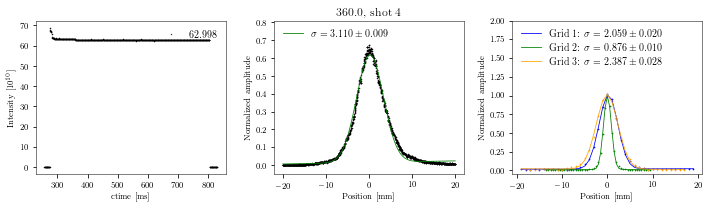

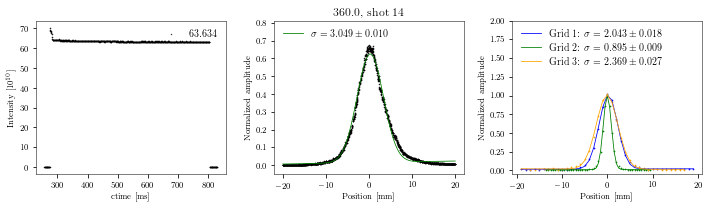

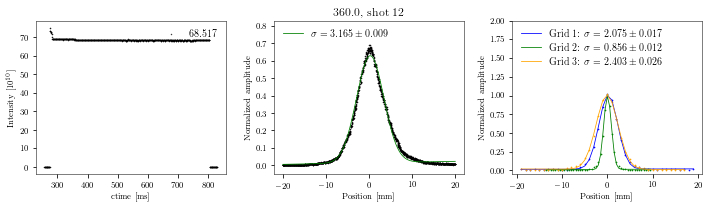

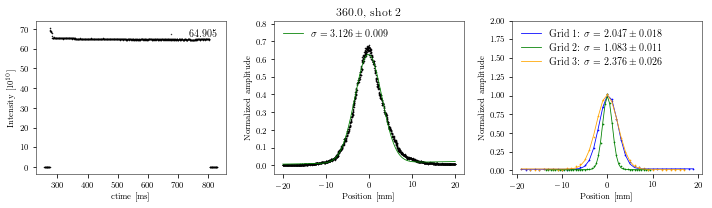

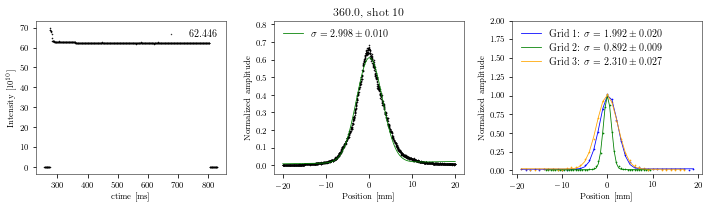

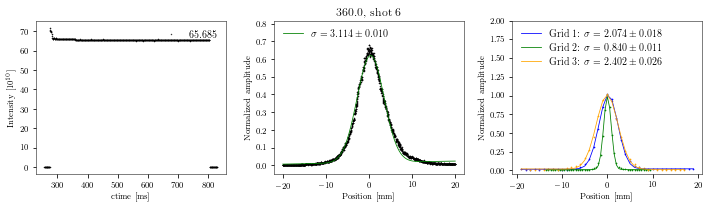

Recorded intensities: [ 62.998  63.634  68.517  64.905  62.446  58.775  65.685]
Intensities after outlier exclusion: [62.998000000000005, 63.634, 0, 64.905000000000001, 62.445999999999998, 0, 65.685000000000002]
Beta wire: 4.1402232551
Beta rel: 0.44528 Gamma rel: 1.11683
1.16190610118 62.998
1.1166297688 63.634
1.20347276097 0
An intensity value was excluded.
1.17356157388 64.905
1.07985693348 62.446
1.02821011417 0
An intensity value was excluded.
1.16470964869 65.685

Normal emittance: [ 1.1619061   1.11662977  1.20347276  1.17356157  1.07985693  1.02821011
  1.16470965] 1.13262098588 0.0567259079375
Normalized emittance: [0.842258483380811, 0.80134789787655991, 0.82571248351822346, 0.78970105876846053, 0.80975305076562987] 0.813754594862 0.0184606275389
Intensity: [ 62.998  63.634  68.517  64.905  62.446  58.775  65.685]

Outliers excluded: [0.842258483380811, 0.80134789787655991, 0.82571248351822346, 0.78970105876846053, 0.80975305076562987] 0.813754594862 0.0184606275389

PROFILE

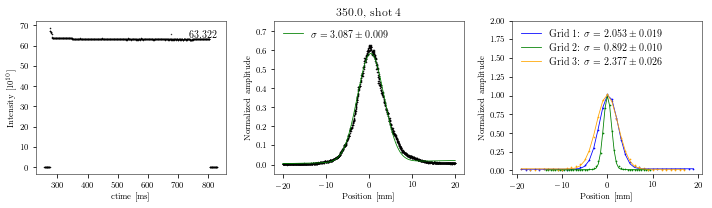

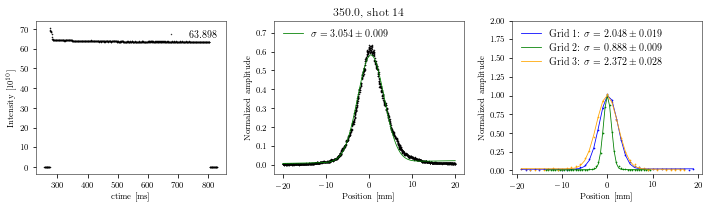

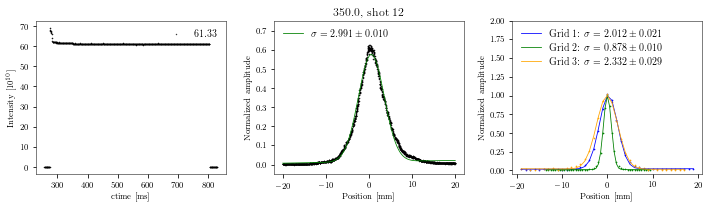

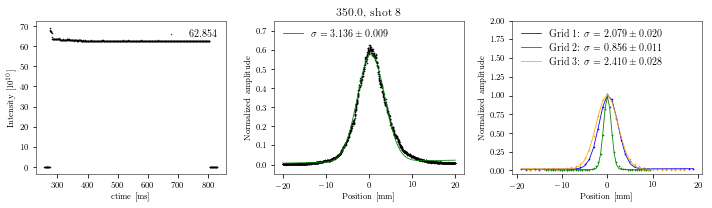

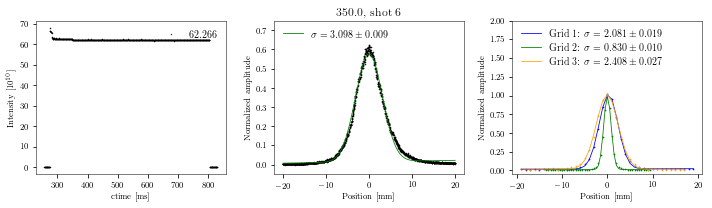

Recorded intensities: [ 63.322  63.898  61.33   62.626  62.434  62.854  62.266]
Intensities after outlier exclusion: [63.322000000000003, 0, 0, 62.626000000000005, 62.434000000000005, 62.853999999999999, 62.265999999999998]
Beta wire: 4.1282985951499995
Beta rel: 0.4273 Gamma rel: 1.10606
1.09088511098 63.322
1.06788942927 0
An intensity value was excluded.
1.02393051454 0
An intensity value was excluded.
1.05969028842 62.626
1.05036434069 62.434
1.12588015654 62.854
1.09891580815 62.266

Normal emittance: [ 1.09088511  1.06788943  1.02393051  1.05969029  1.05036434  1.12588016
  1.09891581] 1.07393652123 0.0314077597089
Normalized emittance: [0.77155460314848612, 0.75782086125988768, 0.75346153317146825, 0.80223484091160369, 0.79041601168628073] 0.775097570036 0.0187095777444
Intensity: [ 63.322  63.898  61.33   62.626  62.434  62.854  62.266]

Outliers excluded: [0.77155460314848612, 0.75782086125988768, 0.75346153317146825, 0.80223484091160369, 0.79041601168628073] 0.775097570036 0.

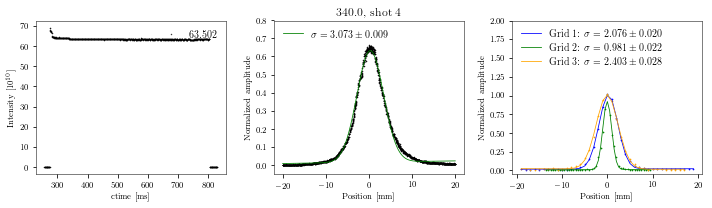

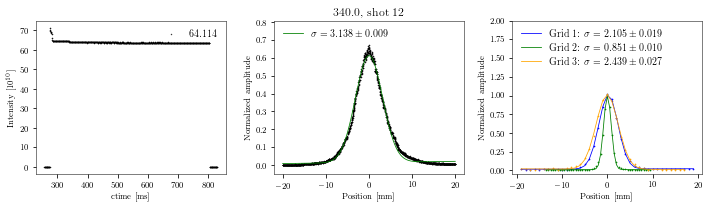

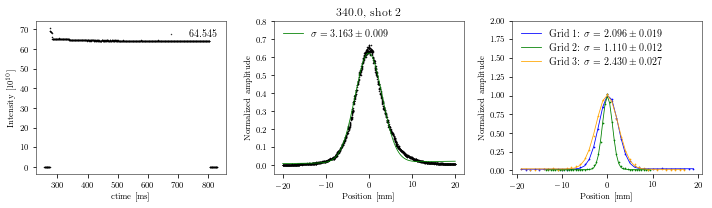

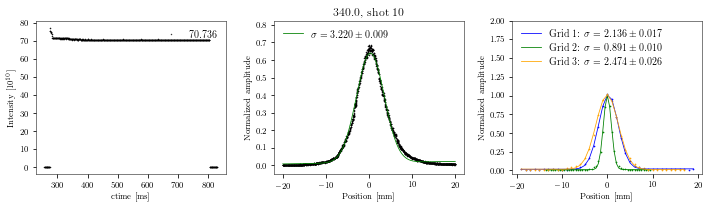

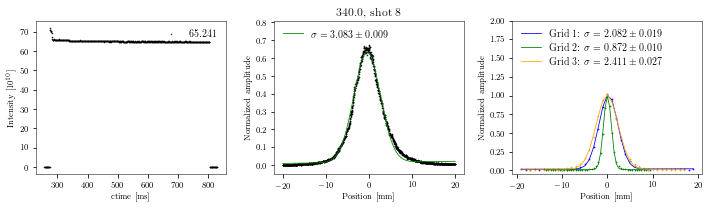

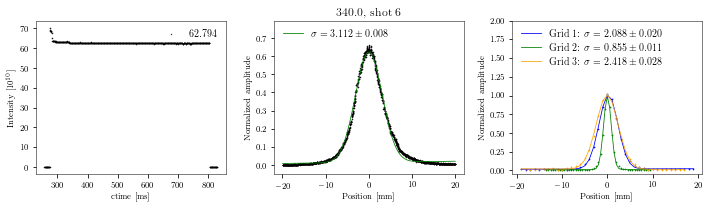

Recorded intensities: [ 63.502  66.333  64.114  64.545  70.736  65.241  62.794]
Intensities after outlier exclusion: [63.502000000000002, 66.332999999999998, 64.114000000000004, 64.545000000000002, 0, 65.241, 0]
Beta wire: 4.11605396315
Beta rel: 0.40967 Gamma rel: 1.09621
1.03060514039 63.502
1.05126600526 66.333
1.07465218821 64.114
1.09150272604 64.545
1.13130891282 0
An intensity value was excluded.
1.03711780964 65.241
1.05674302738 0
An intensity value was excluded.

Normal emittance: [ 1.03060514  1.05126601  1.07465219  1.09150273  1.13130891  1.03711781
  1.05674303] 1.06759940139 0.0324309289022
Normalized emittance: [0.75057918339012497, 0.73295041729350663, 0.77518733628258962, 0.78208478031077977, 0.7351891647972858] 0.755198176415 0.0201946250754
Intensity: [ 63.502  66.333  64.114  64.545  70.736  65.241  62.794]

Outliers excluded: [0.75057918339012497, 0.73295041729350663, 0.77518733628258962, 0.78208478031077977, 0.7351891647972858] 0.755198176415 0.0201946250754

PRO

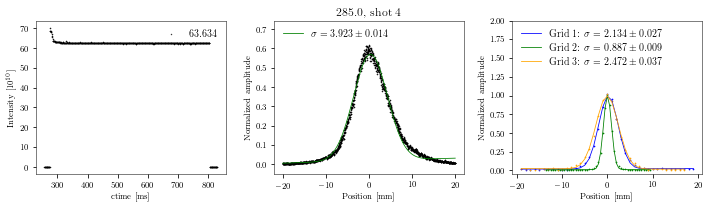

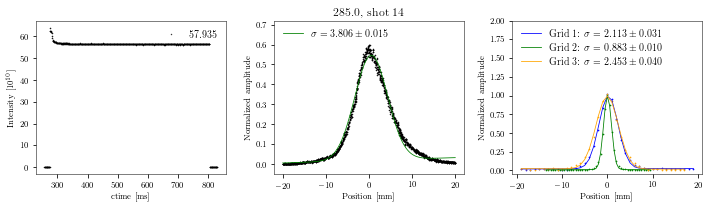

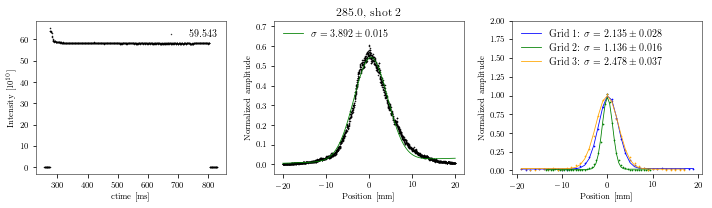

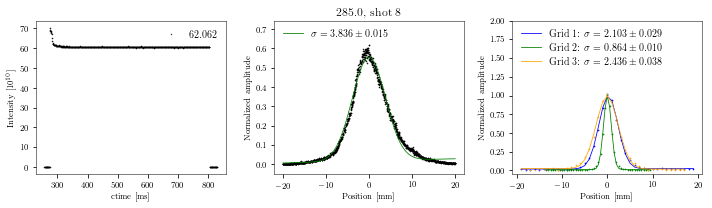

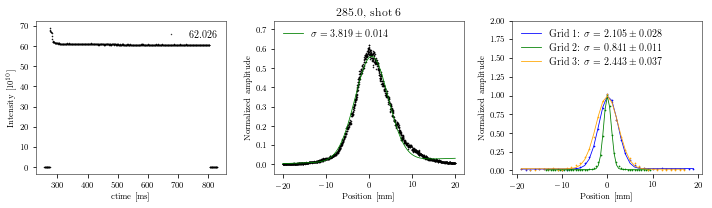

Recorded intensities: [ 63.634  57.935  63.154  59.543  62.89   62.062  62.026]
Intensities after outlier exclusion: [0, 0, 63.154000000000003, 0, 62.890000000000001, 62.062000000000005, 62.026000000000003]
Beta wire: 4.0340042408
Beta rel: 0.32403 Gamma rel: 1.05703
1.30675608317 0
An intensity value was excluded.
1.22970763369 0
An intensity value was excluded.
1.28288879964 63.154
1.28635132908 0
An intensity value was excluded.
1.20322507297 62.89
1.24929877458 62.062
1.23849573351 62.026

Normal emittance: [ 1.30675608  1.22970763  1.2828888   1.28635133  1.20322507  1.24929877
  1.23849573] 1.25667477523 0.0339010970469
Normalized emittance: [0.72587086720235905, 0.68365421245951685, 0.71930281949307484, 0.71349667838327491] 0.710581144385 0.0161508764618
Intensity: [ 63.634  57.935  63.154  59.543  62.89   62.062  62.026]

Outliers excluded: [0.72587086720235905, 0.68365421245951685, 0.71930281949307484, 0.71349667838327491] 0.710581144385 0.0161508764618


In [5]:
emittance_norm = []
error_norm = []
emittance = []
error = []
ctime = []
beta_rel = []
gamma_rel = []
sigma = []
sigma_err = []
intensity = []
intensity_err = []
beta_wire = []
for directory in result_folders:
    print("")
    print(directory)
    cycle_time = float(re.search('TUNE_(.*)_V', directory).group(1))
    data_dict = get_data(directory, cycle_time)
    beta_w, beta, gamma, em_norm, err_norm, em, err, sig, sig_err, intt, int_err = calculate_emittance(data_dict, cycle_time, madx_folder, plane)
    emittance.append(em)
    emittance_norm.append(em_norm)
    ctime.append(cycle_time)
    error.append(err)
    error_norm.append(err_norm)
    beta_rel.append(beta)
    gamma_rel.append(gamma)
    sigma.append(sig)
    sigma_err.append(sig_err)
    intensity.append(intt)
    intensity_err.append(int_err)
    beta_wire.append(beta_w)
    

# Save the data in a file
try:
    os.remove(os.path.join(data_path, "data.txt"))
except OSError:
    pass
with open(os.path.join(data_path, "data.txt"), "a") as dfile:
    dfile.write("%10s %10s %10s %10s %10s %10s %10s %10s %10s %10s \n" % ("# ctime", "b_rel", "g_rel", "beta_y", "int", "int_err", "sigma", "sigma_err", "em", "em_err"))
    for ct, brel, grel, beta, i, i_err, s, s_err, em, err in zip(ctime, beta_rel, gamma_rel, beta_wire, intensity, intensity_err, sigma, sigma_err, emittance_norm, error_norm):
        dfile.write("%10.0f %10.4f %10.4f %10.4f %10.4f %10.4f %10.4f %10.4f %10.4f %10.4f \n" % (ct, brel, grel, beta, i, i_err, s, s_err, em, err))

plt.errorbar(ctime, emittance_norm, yerr=error_norm, fmt='o', color="blue")
plt.xlabel("ctime [ms]")
plt.ylabel("Normalized emittance [um.rad]")
plt.title("Normalized to intensity")
# plt.show()

plt.errorbar(ctime, emittance, yerr=error, fmt='o', color="orange")
plt.xlabel("ctime [ms]")
plt.ylabel("Normalized emittance [um.rad]")
# plt.show()

# plt.scatter(ctime, gamma_rel)
# plt.scatter(ctime, beta_rel)
# plt.xlabel("ctime [ms]")
# plt.ylabel("Normalized emittance [um.rad]")
# plt.show()

plt.savefig(os.path.join(data_path, "emittance.png"), dpi=1000)

A low standard deviation indicates that the data points tend to be close to the mean (also called the expected value) of the set, while a high standard deviation indicates that the data points are spread out over a wider range of values.